In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 823
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
alpha,sigma = 1,1
beta = [1,2.5]
size=100
x1 = np.random.randn(size)
x2 = np.random.randn(size)* .2
y = alpha + beta[0]*x1 +beta[1]*x2 + rng.normal(size=size) * sigma

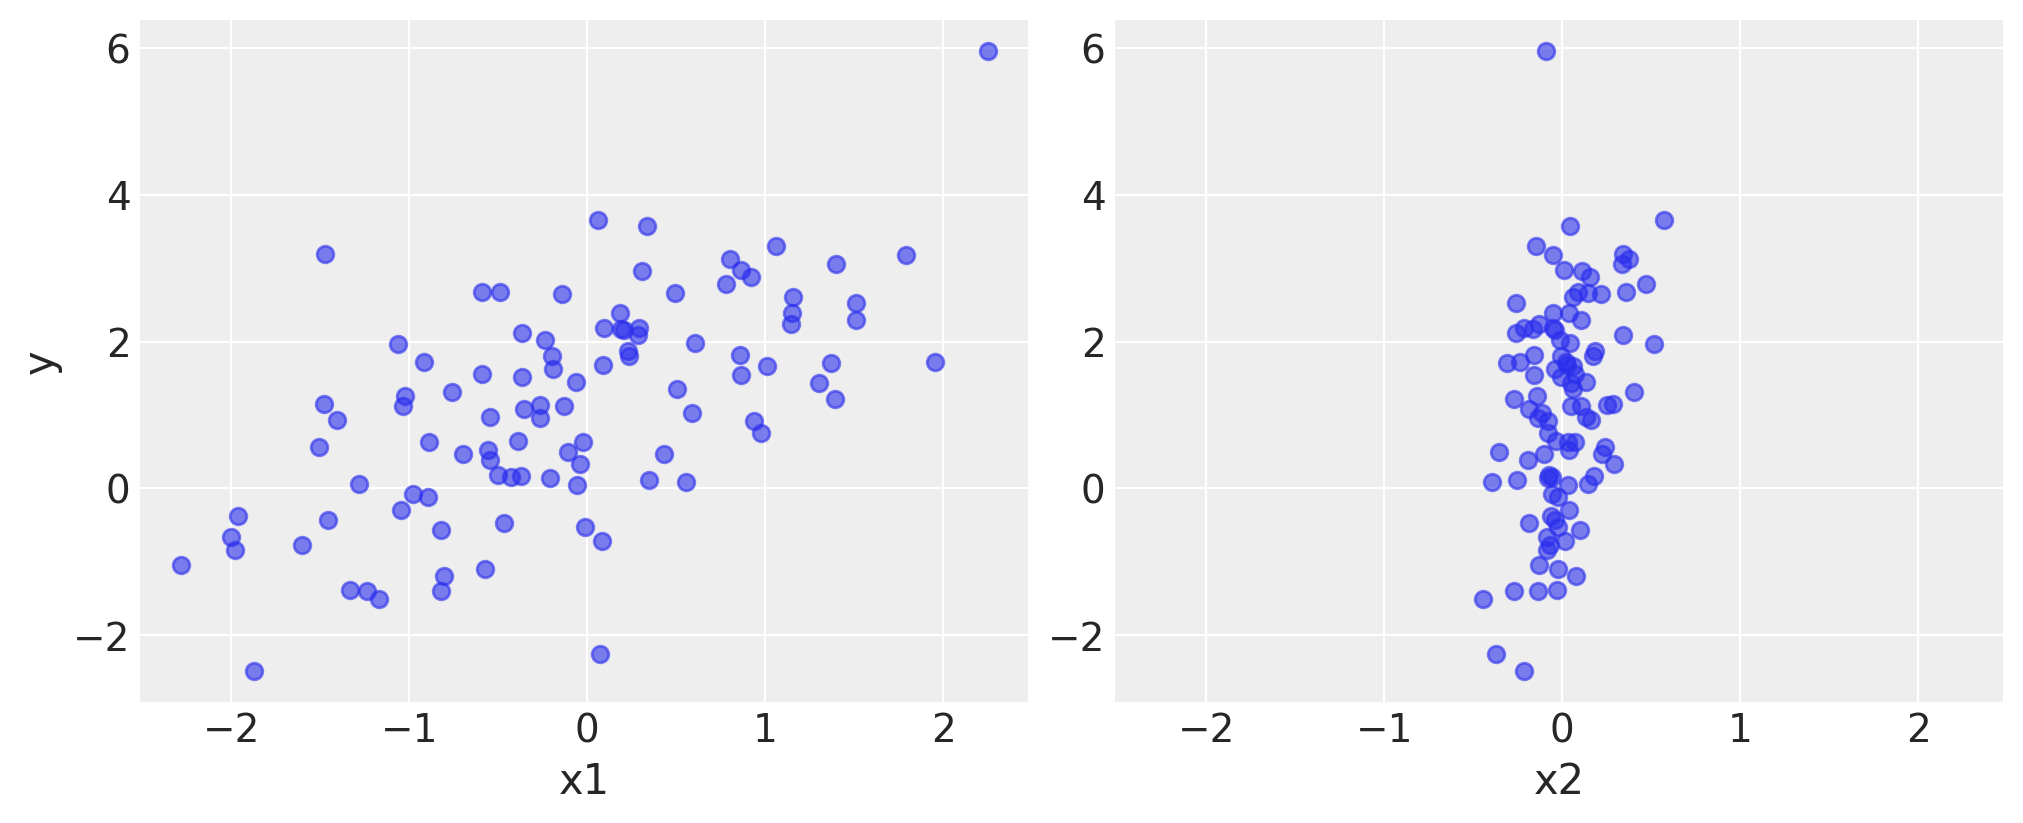

In [4]:
fig, axes = plt.subplots(1,2, sharex= True, figsize=(10,4))
axes[0].scatter(x1, y, alpha =.6)
axes[1].scatter(x2, y, alpha=.6)
axes[0].set_ylabel("y")
axes[0].set_xlabel("x1")
axes[1].set_xlabel("x2");

In [5]:
import pymc as pm
print(f"running on pymc v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


running on pymc v5.1.2


In [10]:
basic_model = pm.Model()
with basic_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    #expected value of outcome
    mu = alpha + beta[0]*x1 + beta[1]*x2
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

In [10]:
with basic_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [11]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [12]:
idata.posterior['alpha'].sel(draw=slice(0,4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.18937071, 1.1650372 , 1.17084035, 1.2650803 , 1.27530269],
       [1.15949694, 1.18401438, 1.35476734, 1.19336567, 1.17076679],
       [1.20584037, 1.2261653 , 1.20265978, 1.20322342, 1.28712858],
       [1.30273307, 1.22642171, 1.22689596, 1.22647367, 1.19613533]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4

In [13]:
with basic_model:
    step = pm.Slice()
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 31 seconds.


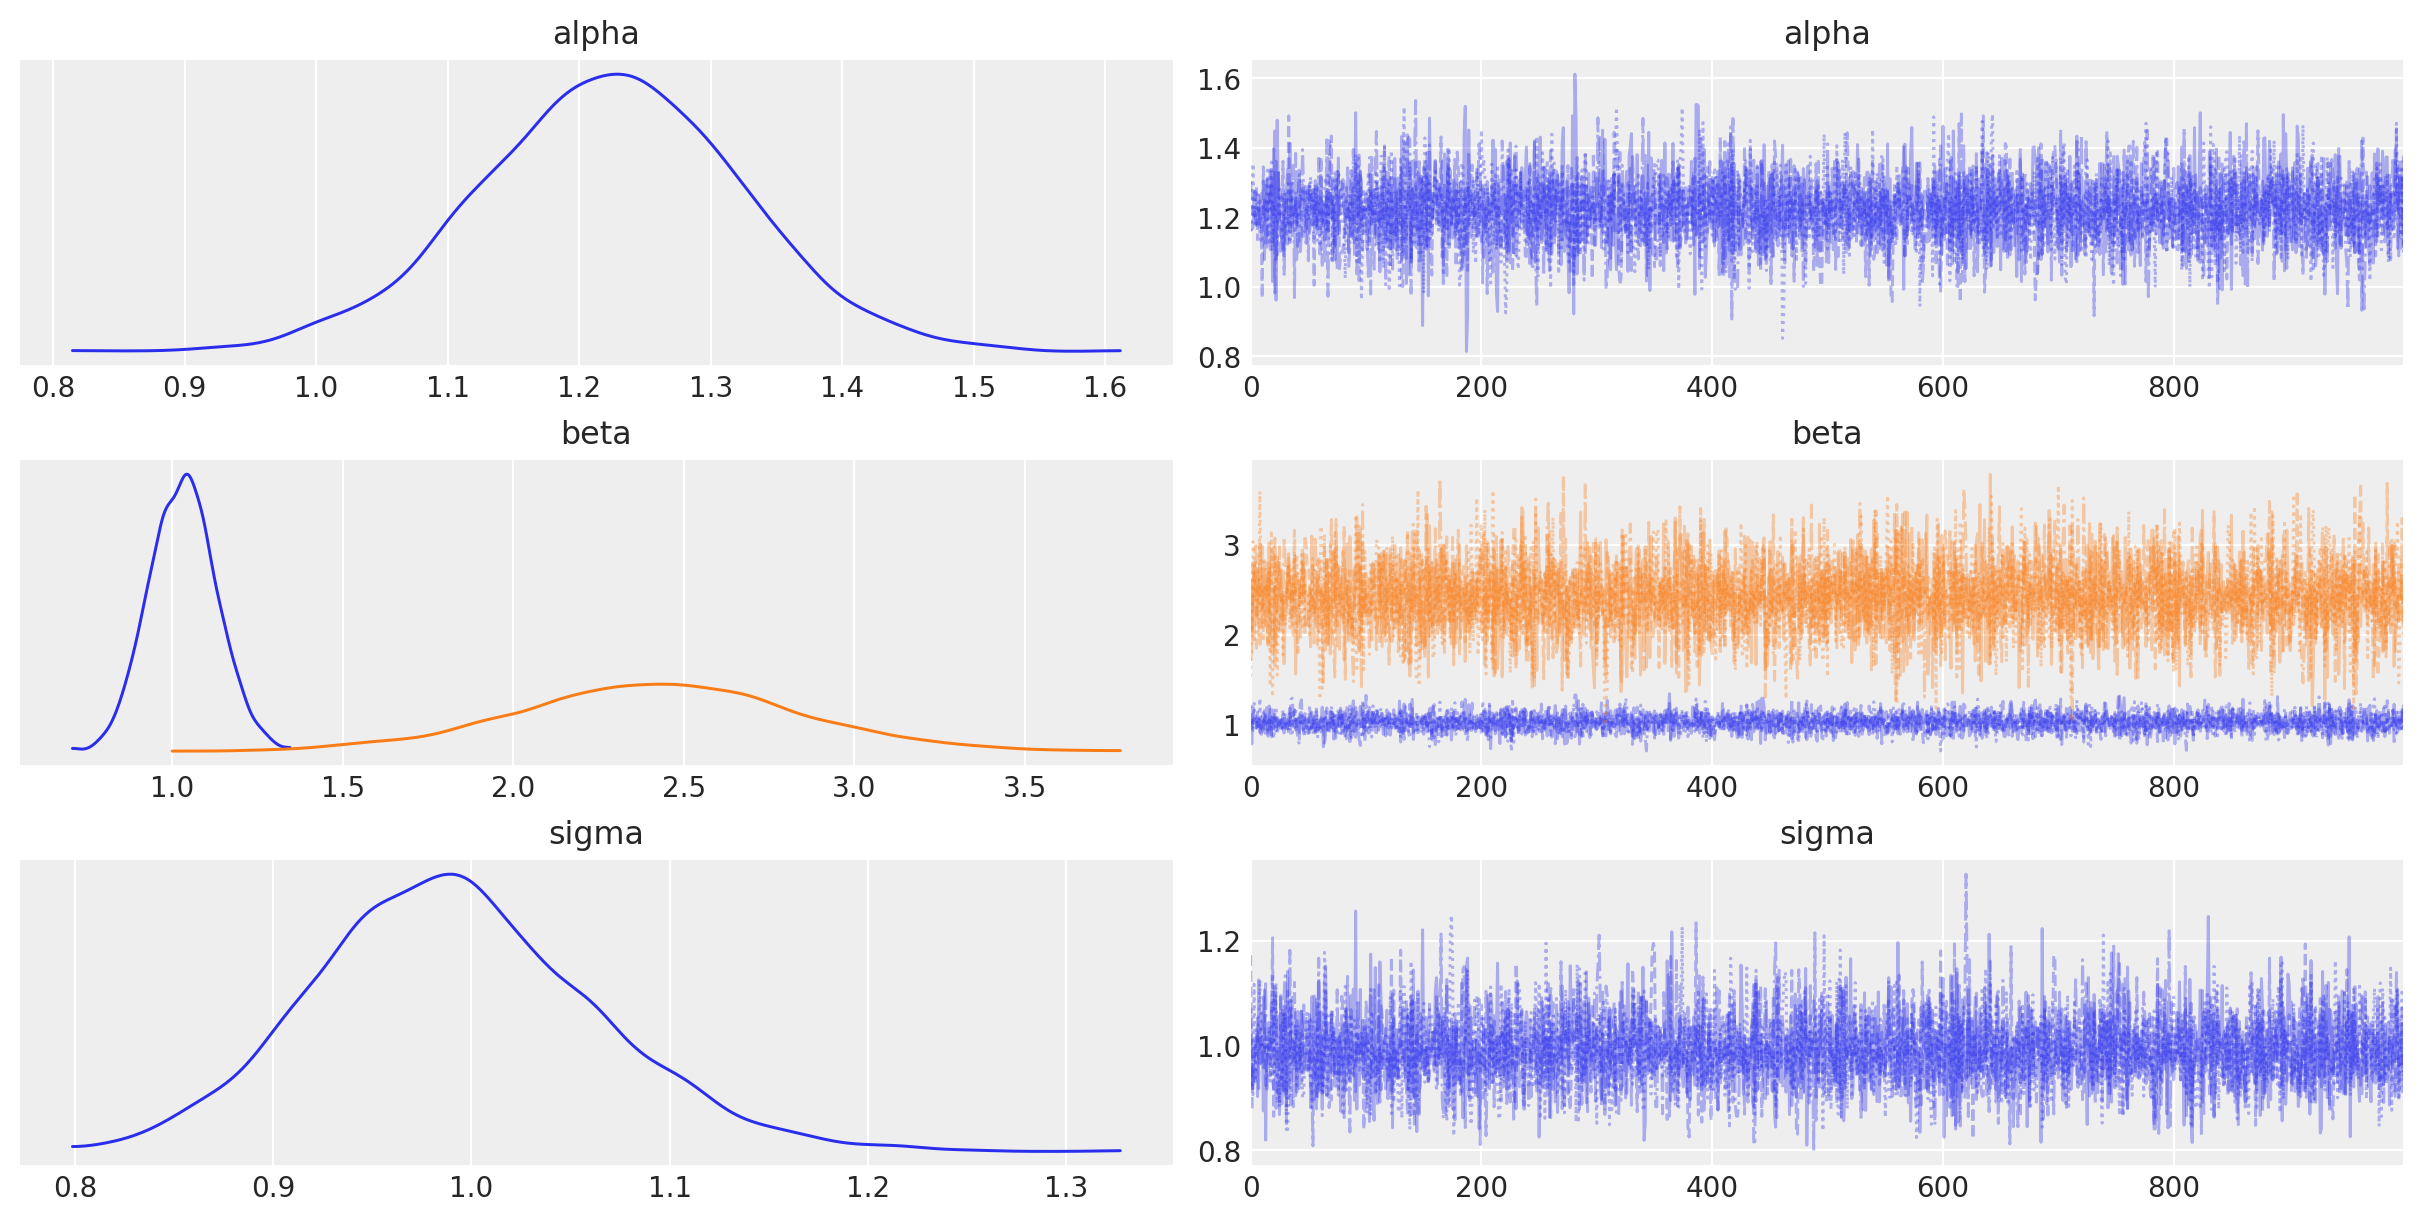

In [14]:
az.plot_trace(idata, combined=True);

In [15]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.22,0.10,1.03,1.41,0.00,0.0,6350.94,2866.34,1.0
beta[0],1.03,0.10,0.85,1.21,0.00,0.0,5437.14,3350.09,1.0
beta[1],2.42,0.41,1.64,3.21,0.01,0.0,5822.69,3497.30,1.0
sigma,0.99,0.07,0.86,1.12,0.00,0.0,5716.78,3245.26,1.0


In [17]:
with basic_model:
    pm.compute_log_likelihood(idata)

In [18]:
basic_model_loo = az.loo(idata)
basic_model_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -142.97     7.63
p_loo        3.90        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [23]:
with basic_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [y_obs]


In [24]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, y_obs_dim_2: 100)
Coordinates:
  * chain        (chain) int32 0 1 2 3
  * draw         (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * y_obs_dim_2  (y_obs_dim_2) int32 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
Data variables:
    y_obs        (chain, draw, y_obs_dim_2) float64 -0.1075 -1.767 ... 1.628
Attributes:
    created_at:                 2023-04-26T13:41:34.184208
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.1.2

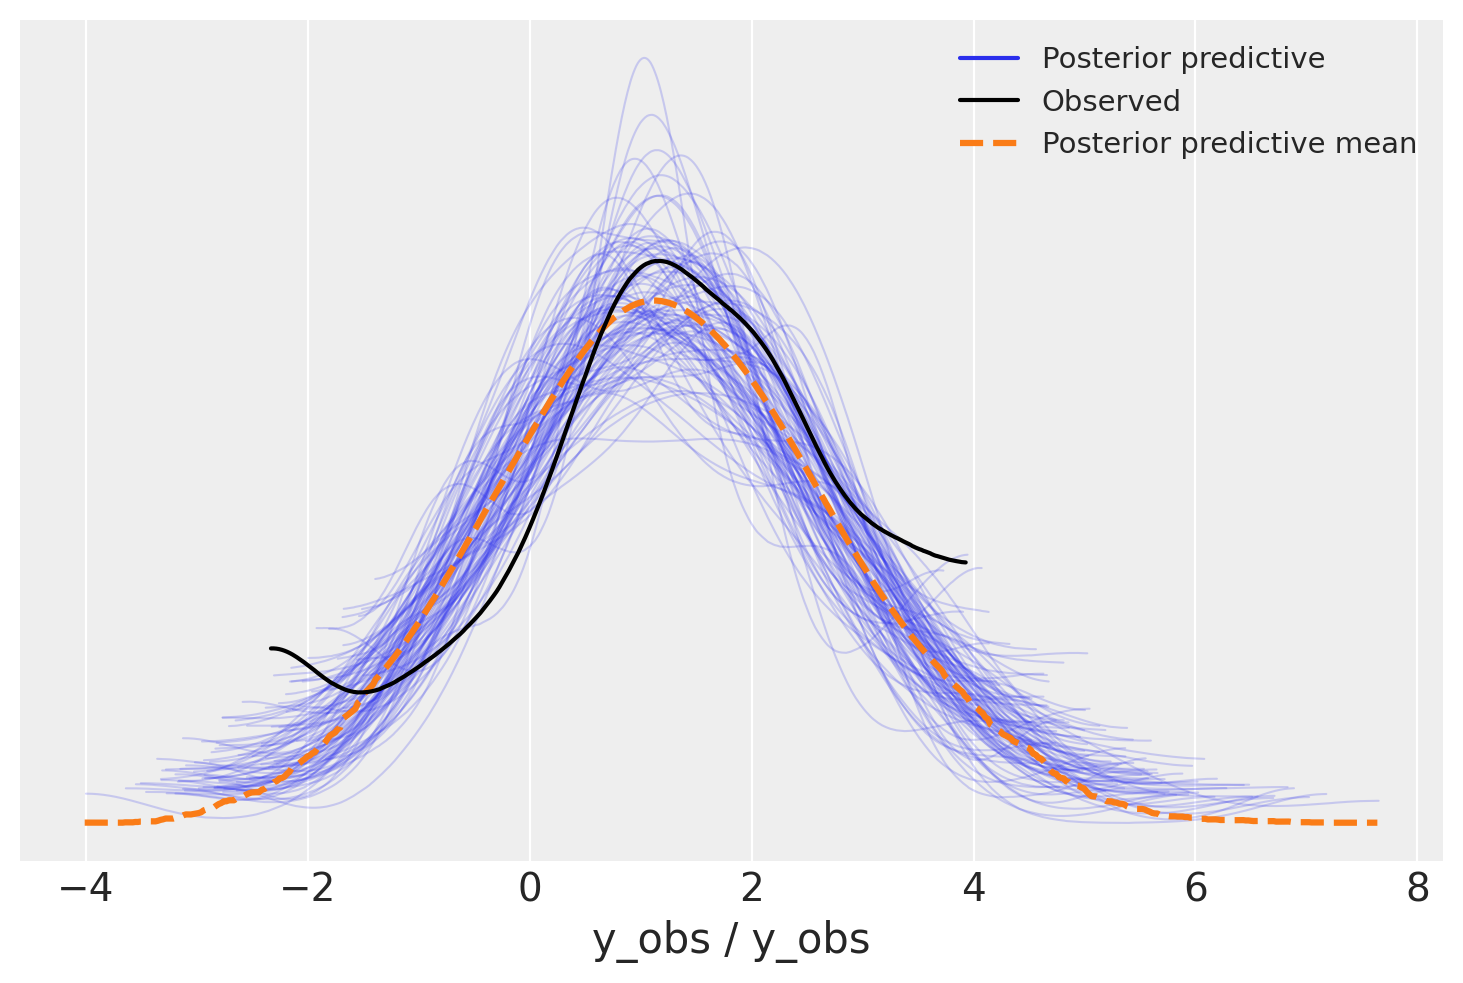

In [25]:
az.plot_ppc(idata, num_pp_samples=100);

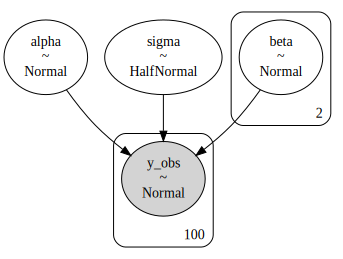

In [30]:
pm.model_to_graphviz(basic_model)

In [37]:
data, group_list = generate()
display(data)

,group,group_idx,x,y
0,one,0,-0.409727,-1.168938
1,one,0,0.381800,0.780641
2,one,0,1.386713,0.207187
3,one,0,1.588249,0.757987
4,one,0,-0.566294,-1.687772
...,...,...,...,...
95,five,4,2.835240,1.524834
96,five,4,3.272680,2.314764
97,five,4,1.247065,1.896673
98,five,4,0.457525,-1.767046


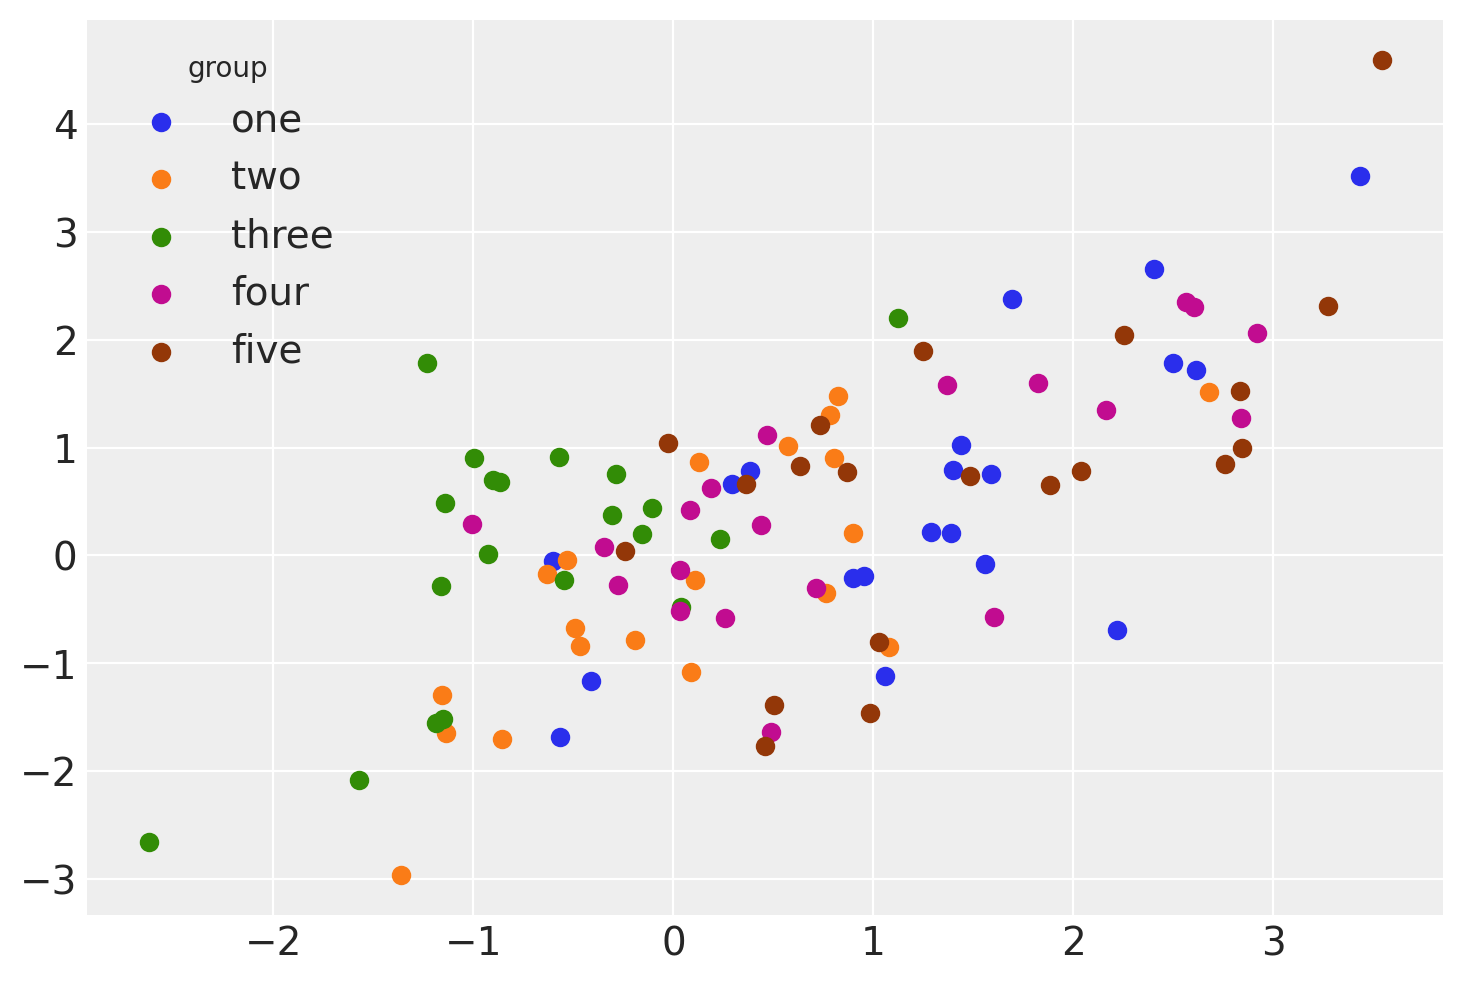

In [39]:
for i, group in enumerate(group_list):
    plt.scatter(
    data.query(f"group_idx=={i}").x,
    data.query(f"group_idx=={i}").y,
    color= f"C{i}",
    label =f"{group}",
    )
plt.legend(title="group");

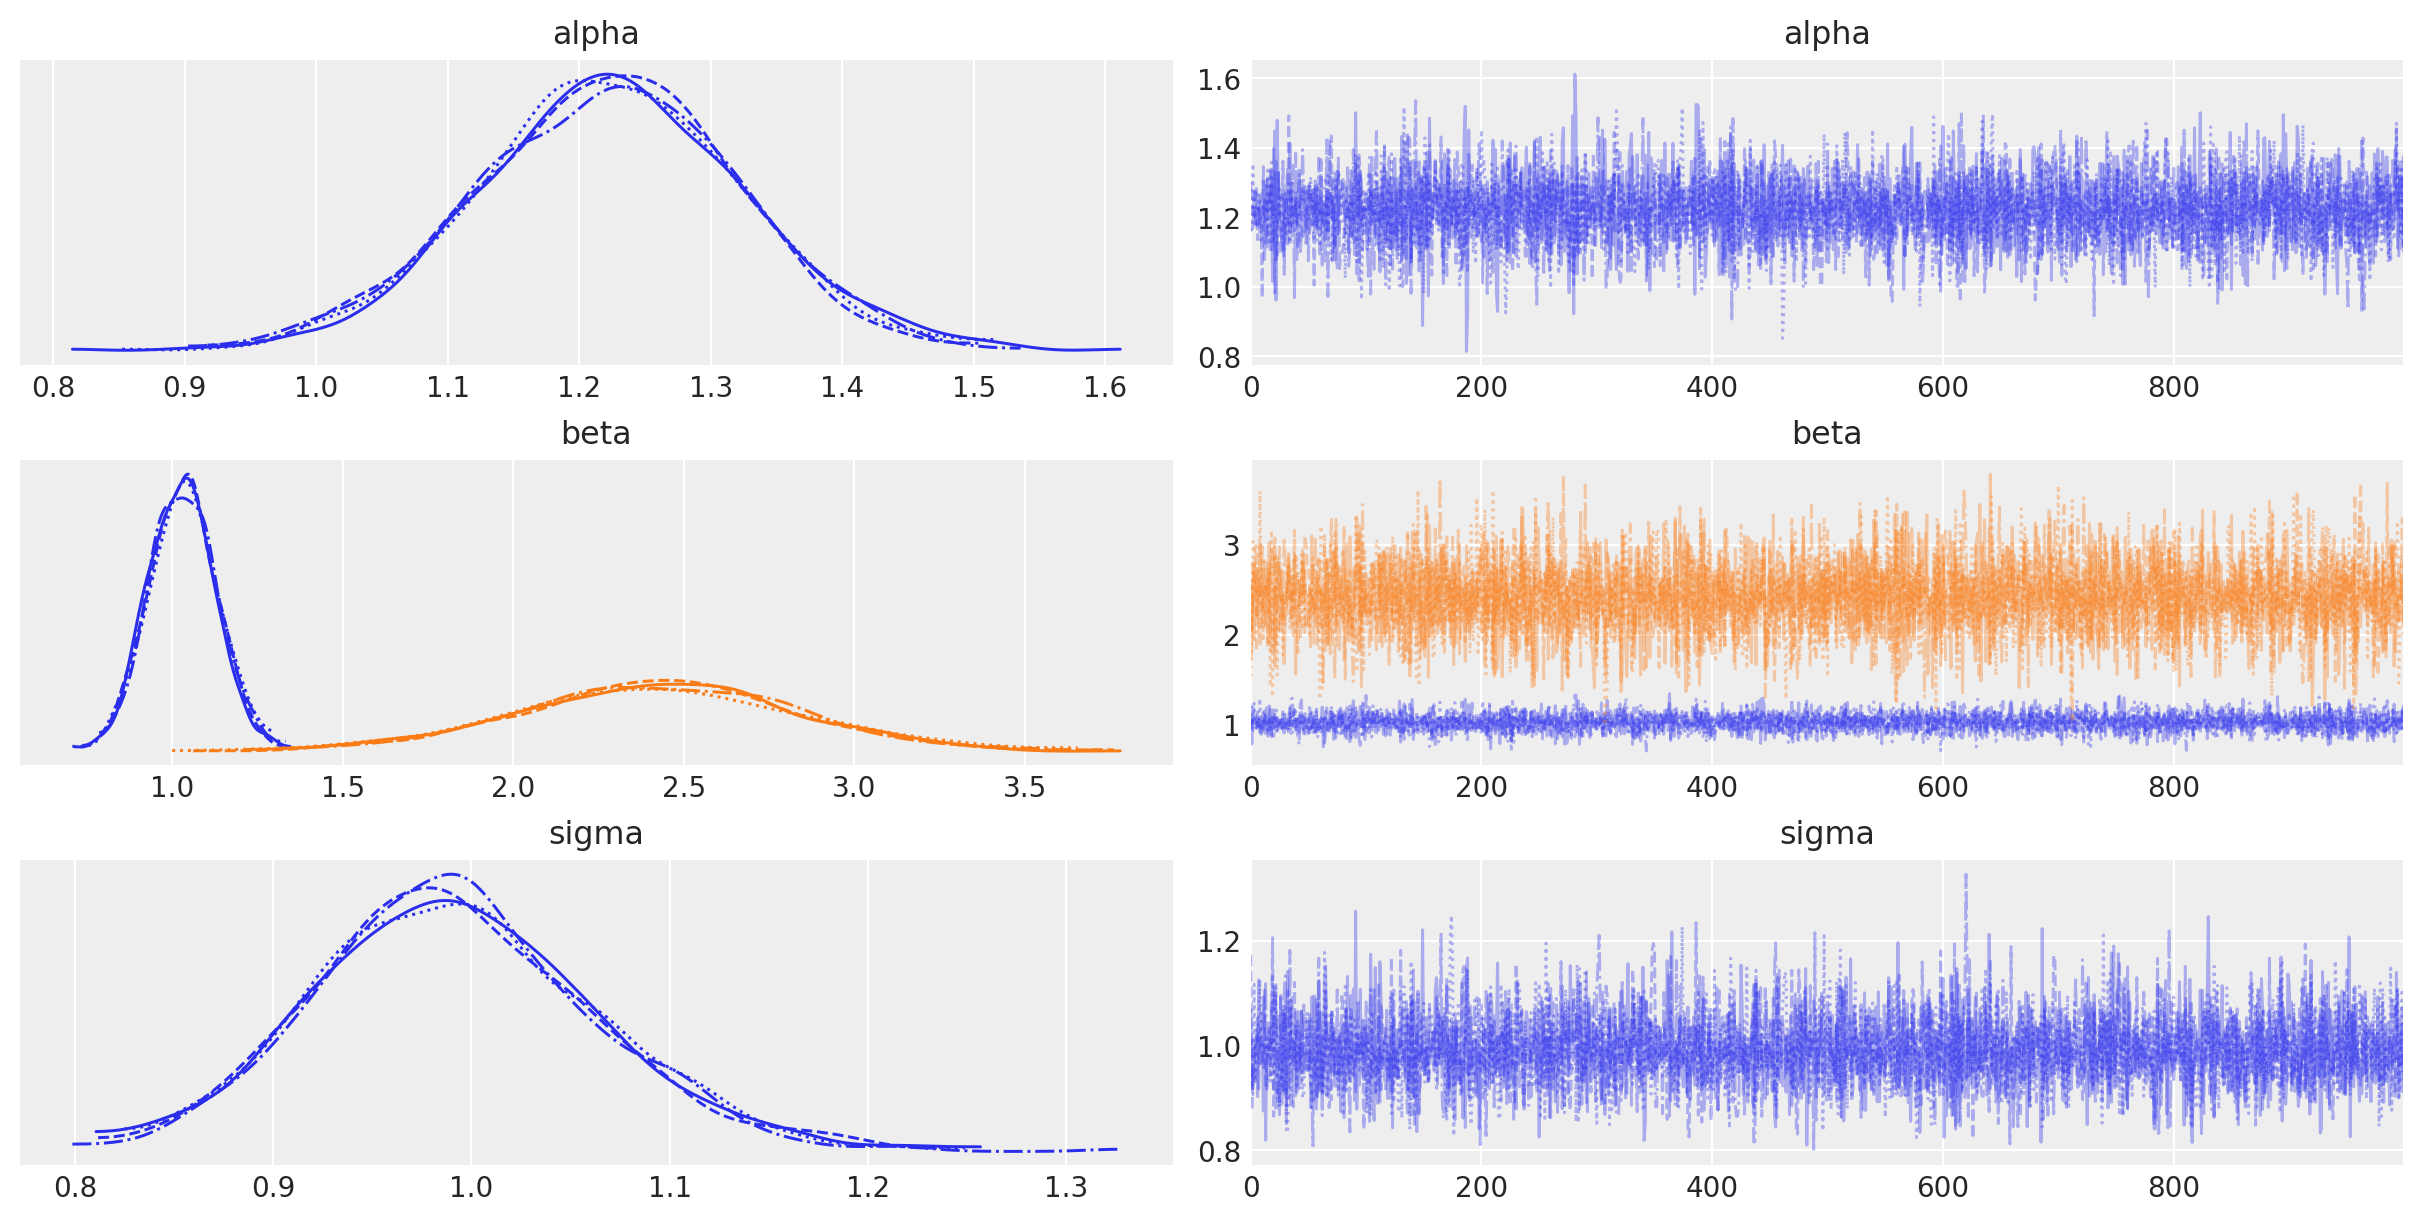

In [53]:
az.plot_trace(idata, filter_vars = "regex");